# Interactive Probability Distributions as a Function of Time

### Objective: To help further develop the manual violin plots and offer alternative methods for the data visualization.

## Imports

In [1]:
%matplotlib inline
import sys
import os
import logging
import numpy
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn
import sklearn
import sklearn.metrics
from bokeh.io import output_notebook, show
output_notebook()
import numpy as np
from bokeh.models import ColumnDataSource, CustomJS, Range1d, Select, Dropdown, LabelSet, Slider
from bokeh.plotting import figure, output_notebook, show, output_file, save
from bokeh.layouts import column, row, gridplot

from metric_querier import ELAsTiCCMetricsQuerier

Loading BokehJS ...

In [2]:
logger = logging.getLogger(__name__)
if not logger.hasHandlers():
    _logout = logging.StreamHandler( sys.stderr )
    logger.addHandler( _logout )
    _formatter = logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s', datefmt='%Y-%m-%d %H:%M:%S' )
    _logout.setFormatter( _formatter )

logger.setLevel( logging.DEBUG )

In [3]:
username = "josephy"
with open( os.path.join(os.getenv("HOME"), "josephy_passwd.txt")) as ifp:
    password = ifp.readline().strip()
    
emq = ELAsTiCCMetricsQuerier( tomusername=username, tompasswd=password, logger=logger )

Substitute the `username` and `password` variables with the appropriate username and file containing your password. Contact Rob Knop (raknop@lbl.gov) for more details.

# Loading in the Data

In [4]:
probhist = emq.probhist()

[2023-06-05 22:51:53 - DEBUG] - Sending query to get probabilistic metrics histogram table
[2023-06-05 22:52:09 - DEBUG] - Got response, pandifying
[2023-06-05 22:52:13 - DEBUG] - Done


Print `probhist` for a better understanding of what you're working with.

In [5]:
# This one is important
# For each true class, a list of "confusion classes" to plot alongside it.
# The right thing to do is hard... you have to know what's in the data already!
confusionclasses = {
    # Ia -> Ia, Ibc, II, PISN, SLSN, TDE
    # 111: [ 111, 112, 113, 135, 131, 132 ],
    111: [111, 113]
}

The variable `cferstodo` defines which classifier we're choosing to analyze.
For a full list of available classifiers enter the following command `list(emq.classifier_info.keys())` 

In [6]:
cferstodo = [ 40 ]
trueclasstodo = [ 111 ]

# Every time bin is overwhelming.  Choose some time bins to do
# Let's do -10 days, 0 days, 30 days, 60 days, and >=100 days
tbinstodo = [5, 7, 13, 19, 27]

print( f"Going to do classifiers: {cferstodo}" )
print( f"Going to do classes: {[emq.classname[i] for i in trueclasstodo]}" )

Going to do classifiers: [40]
Going to do classes: ['Ia']


Let's take a look at what the original version of the plots looked like.

[2023-06-05 22:52:25 - DEBUG] - doing cfer 40, true class Ia


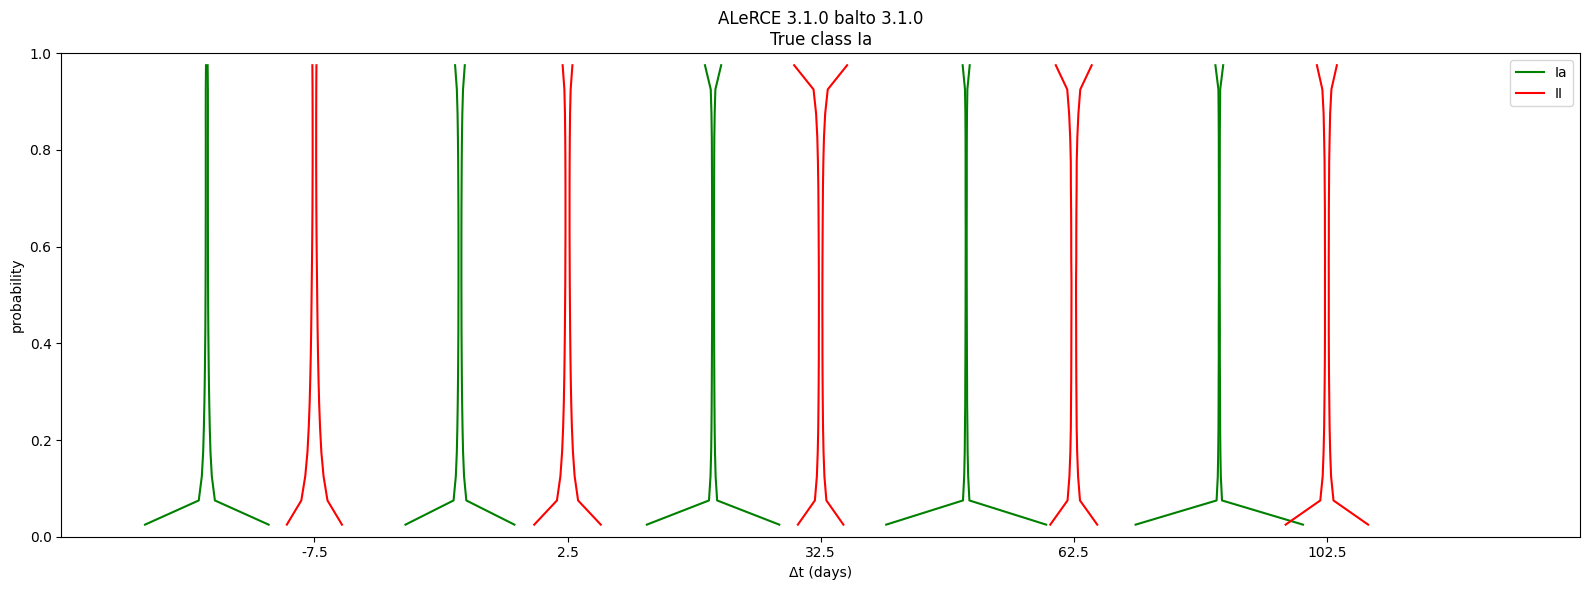

In [7]:
for cfer in cferstodo:
    brokername = emq.classifier_info[cfer]['brokerName']
    brokerversion = emq.classifier_info[cfer]['brokerVersion']
    classifiername = emq.classifier_info[cfer]['classifierName']
    classifierparams = emq.classifier_info[cfer]['classifierParams']
    cfertitle = f'{brokername} {brokerversion} {classifiername} {classifierparams}'
    for trueclass in trueclasstodo:
        logger.debug( f"doing cfer {cfer}, true class {emq.classname[trueclass]}" )
        subdf = probhist.xs( ( cfer, trueclass ), level=( 'classifierId', 'trueClassId' ) )
        probdf = subdf / subdf.groupby( ['classId', 'tbin'] ).sum()
        probdf.reset_index( inplace=True )
        probdf.set_index( ['tbin', 'probbin', 'classId'], inplace=True )
        # Extract just the t bins to do
        probdf = probdf.loc[ pd.IndexSlice[ tbinstodo, :, : ] ]
        # Calculate probabilities
        probdf.reset_index( inplace=True )
        probdf['prob'] = emq.probbin_val( probdf['probbin'] )
        probdf.set_index( [ 'tbin', 'classId' ], inplace=True )
        
        fig = plt.figure( figsize=(16, 6), tight_layout=True )
        ax = fig.add_subplot( 1, 1, 1 )
        ax.set_title( f"{cfertitle}\nTrue class {emq.classname[trueclass]}" )
        
        tdex = numpy.arange( len(tbinstodo) )
        ax.set_xlim( tdex[0] - 1 , tdex[-1] + 1 )
        ax.set_ylim( 0., 1.)
        ax.set_xticks( tdex )
        ax.set_xticklabels( [ emq.tbin_val(i) for i in tbinstodo ] )
        ax.set_xlabel( 'Δt (days)' )
        ax.set_ylabel( 'probability' )
        
        # I'm doing violin plots "manually" here since the actual violin plot methods
        # assume you're feeding it raw data, but what we have is binned data.
        
        for ti in tdex:
            for confdex in range(len(confusionclasses[trueclass])):
                confoff = 0.85 * ( confdex - len(confusionclasses[trueclass])/2. ) / len(confusionclasses[trueclass])
                thist = probdf.xs( ( tbinstodo[ti], confusionclasses[trueclass][confdex] ), level=( 'tbin', 'classId' ) )
                # display(thist)
                yvals = thist['prob']
                xvals = ti + thist['count']
                
                if ( ti == 0 ) :
                    ax.plot( confoff + ti + 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex],
                             label=emq.classname[ confusionclasses[trueclass][confdex] ] )
                else:
                    ax.plot( confoff + ti + 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex] )
                ax.plot( confoff + ti - 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex] )
            
        ax.legend()
        fig.show()
            
        

We define one true class and remove the `for` loop that loops through the 
available time bins and write `ti = 3`, for example. Here's what the output should look like. Note: we got rid of the variable `confoff` to center the plot on its respective time bin.

[2023-06-05 22:53:13 - DEBUG] - doing cfer 40, true class Ia
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


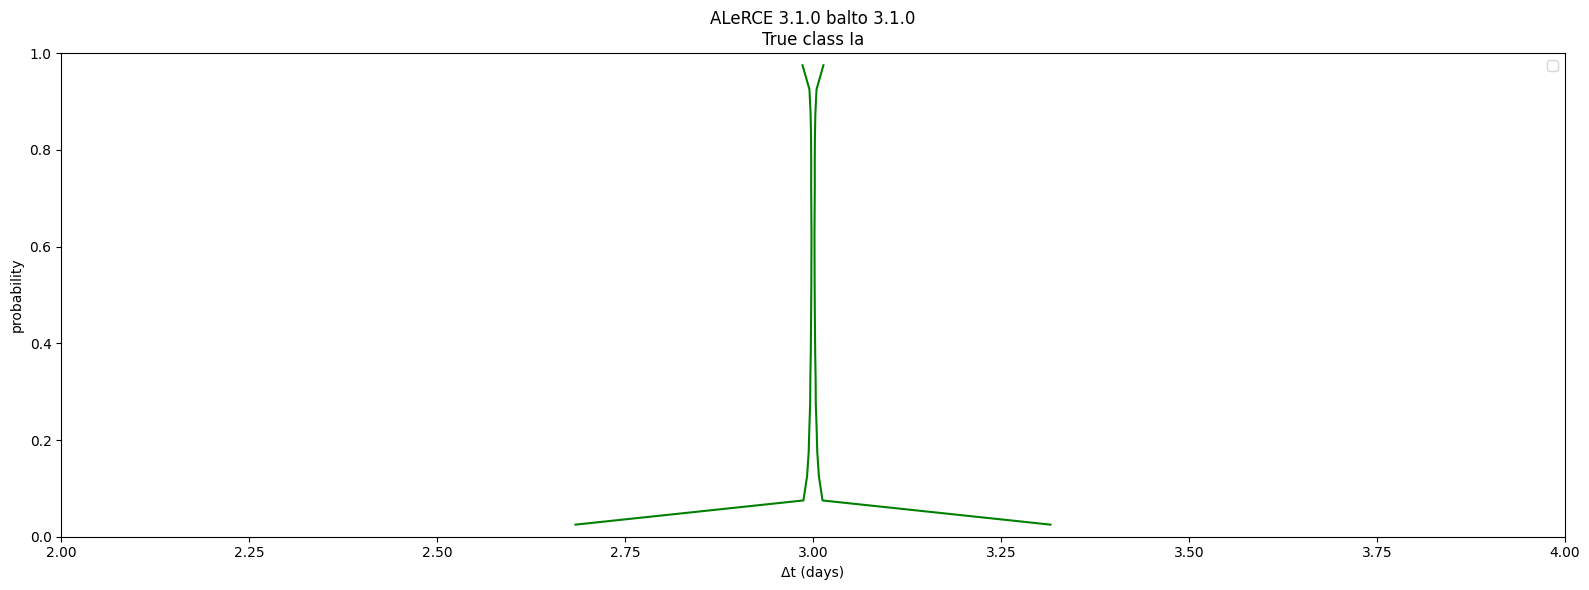

In [8]:
for cfer in cferstodo:
    brokername = emq.classifier_info[cfer]['brokerName']
    brokerversion = emq.classifier_info[cfer]['brokerVersion']
    classifiername = emq.classifier_info[cfer]['classifierName']
    classifierparams = emq.classifier_info[cfer]['classifierParams']
    cfertitle = f'{brokername} {brokerversion} {classifiername} {classifierparams}'
    
    
    trueclass = 111
    logger.debug( f"doing cfer {cfer}, true class {emq.classname[trueclass]}" )
    subdf = probhist.xs( ( cfer, trueclass ), level=( 'classifierId', 'trueClassId' ) )
    probdf = subdf / subdf.groupby( ['classId', 'tbin'] ).sum()
    probdf.reset_index( inplace=True )
    probdf.set_index( ['tbin', 'probbin', 'classId'], inplace=True )
    # Extract just the t bins to do
    probdf = probdf.loc[ pd.IndexSlice[ tbinstodo, :, : ] ]
    # Calculate probabilities
    probdf.reset_index( inplace=True )
    probdf['prob'] = emq.probbin_val( probdf['probbin'] )
    probdf.set_index( [ 'tbin', 'classId' ], inplace=True )

    fig = plt.figure( figsize=(16, 6), tight_layout=True )
    ax = fig.add_subplot( 1, 1, 1 )
    ax.set_title( f"{cfertitle}\nTrue class {emq.classname[trueclass]}" )

    tdex = numpy.arange( len(tbinstodo) )
#     ax.set_xlim( tdex[0] - 1 , tdex[-1] + 1 )
#     ax.set_ylim( 0., 1.)
#     ax.set_xticks( tdex )
#     ax.set_xticklabels( [ emq.tbin_val(i) for i in tbinstodo ] )
    ax.set_xlabel( 'Δt (days)' )
    ax.set_ylabel( 'probability' )

    # I'm doing violin plots "manually" here since the actual violin plot methods
    # assume you're feeding it raw data, but what we have is binned data.
    num_confusions = min(1, len(confusionclasses[trueclass]))
    ti = 3
    for confdex in range(num_confusions):
        confoff = 0.85 * ( confdex - num_confusions/2. ) / num_confusions
        thist = probdf.xs( ( tbinstodo[ti], confusionclasses[trueclass][confdex] ), level=( 'tbin', 'classId' ) )
        # display(thist)
        yvals = thist['prob']
        xvals = ti + thist['count']

        if ( ti == 0 ) :
            ax.plot(ti + 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex],
                     label=emq.classname[ confusionclasses[trueclass][confdex] ] )
        else:
            ax.plot(ti + 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex] )
        ax.plot(ti - 0.4*thist['count'], thist['prob'], color=confusioncolors[confdex] )
    ax.set_xlim( tdex[ti] -1 , tdex[ti]+1)
    ax.set_ylim( 0., 1.)
    ax.legend()
    fig.show()

The following code is incredibly important to the functionality of these plots.
We'll create an empty list called `x_all` and populate this list with multiple lists containing the time bin and the probablility for both the true and confusion class.

In [9]:
num_confusions = len(confusionclasses[trueclass])
ti = 0
x_all = []
for ti in range(len(tbinstodo)):
    ti_list = []
    for confdex in range(num_confusions):
        confoff = 0.85 * ( confdex - num_confusions/2. ) / num_confusions
        thist = probdf.xs( ( tbinstodo[ti], confusionclasses[trueclass][confdex] ), level=( 'tbin', 'classId' ) )
        yvals = thist['prob']
        xvals = thist['count']
        ti_list.append(xvals)
    x_all.append(ti_list)

Now we can plot use `Bokeh`. We plot the manual violin plot as two individual line plots.

In [11]:
p = figure(title="True Class Ia", x_axis_label='days', y_axis_label='Probability')
p.line(ti + 0.4*thist['count'], thist['prob'], legend_label="class", line_width=2)
p.line(ti - 0.4*thist['count'], thist['prob'], legend_label="class", line_width=2)
show(p)

From here, we'll plot both the true class and the confusion class side by side and link the two by linking the plot ranges (see line 16 below). We also went ahead and added a slider using Bokeh's `Slider` function that steps through the time indicies and updates the plot in real time. 

In [13]:
day_value = [emq.tbin_val(i) for i in tbinstodo]
data1 = {'x': day_value[0] + 0.4 * x_all[0][0], 'y': thist['prob']}
data2 = {'x': day_value[0] - 0.4 * x_all[0][0], 'y': thist['prob']}
data3 = {'x': day_value[0] + 0.4 * x_all[0][1], 'y': thist['prob']}
data4 = {'x': day_value[0] - 0.4 * x_all[0][1], 'y': thist['prob']}
source1 = ColumnDataSource(data=data1)
source2 = ColumnDataSource(data=data2)
source3 = ColumnDataSource(data=data3)
source4 = ColumnDataSource(data=data4)

p1 = figure(title="True Class: Ia", x_axis_label='days', y_axis_label='Probability')
p1.line('x', 'y', source=source1, legend_label="class", line_width=2)
p1.line('x', 'y', source=source2, legend_label="class", line_width=2)

p2 = figure(title="Confusion Class: II", x_axis_label='days', y_axis_label='Probability',
            x_range=p1.x_range, y_range=p1.y_range)
p2.line('x', 'y', source=source3, legend_label="class", line_width=2, color="#c02942")
p2.line('x', 'y', source=source4, legend_label="class", line_width=2, color="#c02942")

callback = CustomJS(args=dict(source1=source1, source2=source2, source3=source3, source4=source4, x_all=x_all, day_value=day_value), code="""
    var data1 = source1.data;
    var data2 = source2.data;
    var data3 = source3.data;
    var data4 = source4.data;
    var f = cb_obj.value;

    var x1 = data1['x'];
    var y1 = data1['y'];
    var x2 = data2['x'];
    var y2 = data2['y'];
    var x3 = data3['x'];
    var y3 = data3['y'];
    var x4 = data4['x'];
    var y4 = data4['y'];
    var x_all0 = x_all[f][0];
    var x_all1 = x_all[f][1];
    

    for (var i = 0; i < x1.length; i++) {
        x1[i] = day_value[f] + 0.4 * x_all0[i];
        x2[i] = day_value[f] - 0.4 * x_all0[i];
        x3[i] = day_value[f] + 0.4 * x_all1[i];
        x4[i] = day_value[f] - 0.4 * x_all1[i];
    }

    source1.change.emit();
    source2.change.emit();
    source3.change.emit();
    source4.change.emit();
""")


slider = Slider(start=0, end=4, value=0, step=1, title="Time Index")
slider.js_on_change('value', callback)

layout = column(slider, row(p1, p2))
output_file(filename='/epyc/users/joseph02/public_html/elasticc_interactive_vio_plot.html')
save(layout)
#show(layout)

## Next Steps

The ability to display both the true and confusion classes next to each other is helpful when looking at probabilities for specific time bins. Unfortunately, the manual violin plots make it difficult to discern samll differences in data. To improve the visualiztion, we propose the implementation of a stacked-bar plot using Bokeh's `hbar_stack`. 

Adding more confusion classes and interactivity that allows for the selection of various classes could also be helpful.